In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread


from tqdm import tqdm
import pickle

# 병렬연산
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings(action='ignore')

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

In [ ]:
### 사용자 정의 함수
%cd /content/drive/MyDrive/project3

# Add the paths to the modules to the Python path
import sys
sys.path.append(os.path.abspath('./code/image_function'))

from image_load import resize_image, load_image, load_and_resize_images
from vram_reset import reset_vram

/content/drive/.shortcut-targets-by-id/1gdU-KuXDUU7v2o8X7TdV0JgGiz603mCc/project3


In [ ]:
def load_image(datadir,img_new_size, pic_new_cnt) :

  food_middle_list = sorted(os.listdir(datadir)) # 중분류
  food_list = [] # 음식이름
  food_path_list = [] # 음식이름 경로

  for food_middle in food_middle_list:
    middle_path = os.path.join(datadir,food_middle)
    food_name_list = os.listdir(middle_path)

    for food in food_name_list:
        path = os.path.join(middle_path,food)
        food_path_list.append(path)

        name = path.split('/')[-1]
        food_list.append(name)

  image_li, target_li, except_li = load_and_resize_images(food_path_list, food_list, img_size = img_new_size, pic_cnt = pic_new_cnt)

  return image_li, target_li, except_li

image_li, target_li, except_li = load_image('/content/drive/MyDrive/project3/data/traindata/selected_image_color',(224,224),100)

Processing images: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


In [ ]:
def preprocessing_image(image_list, target_list):

  # 카테고리랑 숫자로 바꾼 값 dict형태로 만들기
  categories_label = {category:i for i, category in enumerate(np.unique(target_list))}
  # target값을 숫자로 변형
  target_num = np.array([categories_label[category] for category in target_list], dtype=np.int8)

  X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42 )

  # 정규화
  X_train = X_train / 255.0
  X_test = X_test / 255.0

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocessing_image(image_li, target_li)

In [ ]:
def VGG16(input_shape):
# VGG16 모델
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=input_shape),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = VGG16(input_shape = (224,224,3))
history = model.fit(X_train,y_train,epochs = 100,validation_split = 0.2)

Epoch 1/100
4/4 [==============================] - 25s 539ms/step - loss: 2.8823 - accuracy: 0.4922 - val_loss: 0.6830 - val_accuracy: 0.5625
Epoch 2/100
4/4 [==============================] - 2s 444ms/step - loss: 0.6980 - accuracy: 0.4766 - val_loss: 0.6938 - val_accuracy: 0.4375
Epoch 3/100
4/4 [==============================] - 2s 440ms/step - loss: 0.6960 - accuracy: 0.4297 - val_loss: 0.6936 - val_accuracy: 0.4375
Epoch 4/100
4/4 [==============================] - 2s 439ms/step - loss: 0.6932 - accuracy: 0.4922 - val_loss: 0.6928 - val_accuracy: 0.4688
Epoch 5/100
4/4 [==============================] - 2s 439ms/step - loss: 0.6894 - accuracy: 0.5703 - val_loss: 0.6619 - val_accuracy: 0.6250
Epoch 6/100
4/4 [==============================] - 2s 437ms/step - loss: 0.8072 - accuracy: 0.6172 - val_loss: 0.7018 - val_accuracy: 0.4375
Epoch 7/100
4/4 [==============================] - 2s 433ms/step - loss: 0.6938 - accuracy: 0.5078 - val_loss: 0.7056 - val_accuracy: 0.4375
Epoch 8/100


In [ ]:
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

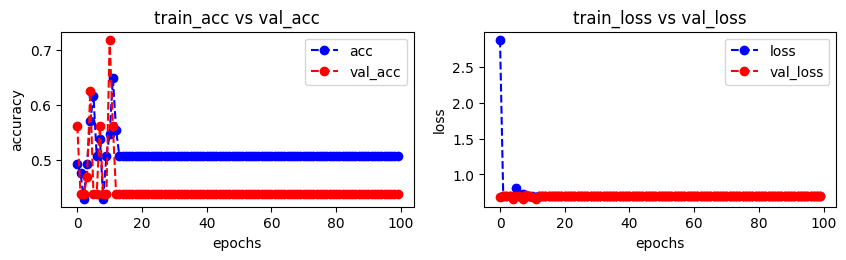

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [ ]:

predictions = model.predict(X_test)

  # Convert the logits to probabilities
probabilities = tf.nn.softmax(predictions)

  # Get the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

  # Compare the predicted classes with the actual classes
comparison = list(zip(predicted_classes, y_test))

  # Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predicted_classes[i]}, Actual: {y_test[i]}')

2/2 [==============================] - 2s 2s/step
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
